In [ ]:
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
import cv2
import imgaug.augmenters as iaa
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
def load_images_and_masks(data_dir, masks_dir):
    """
    Load images and their corresponding masks from specified directories.

    Parameters:
    - data_dir: Directory containing the original images.
    - masks_dir: Directory containing the corresponding masks.

    Returns:
    - A tuple of two lists: (images, masks).
    """
    images = []
    masks = []
    for img_name in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_name)
        mask_path = os.path.join(masks_dir, img_name)  # Assuming mask filenames match image filenames
        if os.path.isfile(img_path) and os.path.isfile(mask_path):
            images.append(cv2.imread(img_path))
            masks.append(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE))
    return images, masks

In [ ]:
# Paths configuration for loading and saving images/masks
data_dir = r"C:\Users\ASUS\Desktop\segmentation & cropping\segmentation_task\segmentation_data43_resized_cropped_split\train\data43_original"
masks_dir = r"C:\Users\ASUS\Desktop\segmentation & cropping\segmentation_task\segmentation_data43_resized_cropped_split\train\data43_masks"
save_path_images = r"C:\Users\ASUS\Desktop\segmentation & cropping\segmentation_task\segmentation_data43_resized_cropped_split/augmented_train/data43_original"
save_path_masks = r"C:\Users\ASUS\Desktop\segmentation & cropping\segmentation_task\segmentation_data43_resized_cropped_split/augmented_train/data43_masks"

# Load images and masks
images, masks = load_images_and_masks(data_dir, masks_dir)

In [ ]:
print(len(images))
print(len(masks))

88
88


In [ ]:
class ElasticDeformation(ImageOnlyTransform):
    """
    Applies elastic deformation to an image.
    This class is a wrapper for imgaug's ElasticTransformation, making it compatible with albumentations' pipelines.

    Parameters:
    - alpha: The scaling factor that controls the intensity of the deformation.
    - sigma: The smoothness of the deformation field. Smaller values make the deformation more local.
    """
    def __init__(self, alpha=20, sigma=10, always_apply=False, p=1.0):
        super(ElasticDeformation, self).__init__(always_apply, p)
        self.alpha = alpha
        self.sigma = sigma

    def apply(self, img, **params):
        """
        Apply the transformation.

        Parameters:
        - img: The input image to apply the deformation.

        Returns:
        - The deformed image.
        """
        aug = iaa.Sequential([iaa.ElasticTransformation(alpha=self.alpha, sigma=self.sigma)])
        img_aug = aug.augment_image(img)
        return img_aug


# Step 1: Define the augmentation pipeline for both image and mask
spatial_augmentation = A.Compose([
    ###Non-color-based augmentations
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
    A.Rotate(limit=5, p=1),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=1, border_mode=cv2.BORDER_CONSTANT),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=1, border_mode=cv2.BORDER_CONSTANT, shift_limit_y=0.1),
    A.ElasticTransform(alpha=40, sigma=10),
], additional_targets={'mask': 'image'})

# Step 2: Define the augmentation pipeline for the image only
image_only_augmentation = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.10, contrast_limit=0, p=1),
    A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=0.10, p=1),
    A.HueSaturationValue(sat_shift_limit=5, val_shift_limit=0, hue_shift_limit=0, p=1),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=0, val_shift_limit=0, p=1),
    A.RGBShift(r_shift_limit=0, g_shift_limit=10, b_shift_limit=0, p=1),
])

def apply_augmentations(image, mask):
    """
    Applies the defined augmentations to the image and mask. This function
    now applies all augmentations three times to each image-mask pair.
    """

    # Apply spatial augmentations to both image and mask
    augmented = spatial_augmentation(image=image, mask=mask)
    image, mask = augmented['image'], augmented['mask']

    # Apply image-only augmentations to the image
    image = image_only_augmentation(image=image)['image']

    return image, mask

def apply_and_save_augmentations(images, masks, save_path_images, save_path_masks):
    """
    Applies the defined augmentations to each image-mask pair and saves the results in RGB format.

    Parameters:
    - images: List of images to augment.
    - masks: List of corresponding masks to augment.
    - save_path_images: Path to save the augmented images.
    - save_path_masks: Path to save the augmented masks.
    - apply_augmentations: Function to apply augmentations to the image and mask.
    """
    os.makedirs(save_path_images, exist_ok=True)
    os.makedirs(save_path_masks, exist_ok=True)

    for idx, (image, mask) in enumerate(tqdm(zip(images, masks), total=len(images))):
        image_aug, mask_aug = apply_augmentations(image, mask)

        cv2.imwrite(os.path.join(save_path_images, f"aug0_{idx}.jpg"), image_aug)
        cv2.imwrite(os.path.join(save_path_masks, f"aug0_{idx}.png"), mask_aug)

    for idx, (image, mask) in enumerate(tqdm(zip(images, masks), total=len(images))):
        image_aug, mask_aug = apply_augmentations(image, mask)

        cv2.imwrite(os.path.join(save_path_images, f"aug1_{idx}.jpg"), image_aug)
        cv2.imwrite(os.path.join(save_path_masks, f"aug1_{idx}.png"), mask_aug)

    for idx, (image, mask) in enumerate(tqdm(zip(images, masks), total=len(images))):
        image_aug, mask_aug = apply_augmentations(image, mask)

        cv2.imwrite(os.path.join(save_path_images, f"aug2_{idx}.jpg"), image_aug)
        cv2.imwrite(os.path.join(save_path_masks, f"aug2_{idx}.png"), mask_aug)

    for idx, (image, mask) in enumerate(tqdm(zip(images, masks), total=len(images))):
        image_aug, mask_aug = apply_augmentations(image, mask)

        cv2.imwrite(os.path.join(save_path_images, f"aug3_{idx}.jpg"), image_aug)
        cv2.imwrite(os.path.join(save_path_masks, f"aug3_{idx}.png"), mask_aug)

    for idx, (image, mask) in enumerate(tqdm(zip(images, masks), total=len(images))):
        image_aug, mask_aug = apply_augmentations(image, mask)

        cv2.imwrite(os.path.join(save_path_images, f"aug4_{idx}.jpg"), image_aug)
        cv2.imwrite(os.path.join(save_path_masks, f"aug4_{idx}.png"), mask_aug)

    for idx, (image, mask) in enumerate(tqdm(zip(images, masks), total=len(images))):
        image_aug, mask_aug = apply_augmentations(image, mask)

        cv2.imwrite(os.path.join(save_path_images, f"aug5_{idx}.jpg"), image_aug)
        cv2.imwrite(os.path.join(save_path_masks, f"aug5_{idx}.png"), mask_aug)

In [ ]:
# Apply augmentations and save results
apply_and_save_augmentations(images, masks, save_path_images, save_path_masks)

100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:01<00:00, 50.38it/s]


## Viewing augmentations for a single image

In [ ]:
# Load the image
image_path = "data_68.jpg"  # Update this path to your actual image file
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

In [ ]:
# Define a list of augmentations grouped by type
augmentations = [
    ("Green shift", A.RGBShift(r_shift_limit=0, g_shift_limit=25, b_shift_limit=0, p=1)),
    ("Brightness", A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0, p=1)),
    ("Contrast", A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=0.15, p=1)),
    ("Saturation", A.HueSaturationValue(sat_shift_limit=10, val_shift_limit=0, hue_shift_limit=0, p=1)),
    ("Hue", A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=0, val_shift_limit=0, p=1)),

    # Non-color-based augmentations
    ("Horizontal flip", A.HorizontalFlip(p=1)),
    ("Vertical flip", A.VerticalFlip(p=1)),
    ("Rotate", A.Rotate(limit=20, p=1)),
    ("Width shift", A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0, rotate_limit=0, p=1, border_mode=cv2.BORDER_CONSTANT)),
    ("Height shift", A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0, rotate_limit=0, p=1, border_mode=cv2.BORDER_CONSTANT, shift_limit_y=0.2)),
    ("Elastic transformation", A.ElasticTransform(alpha=40, sigma=10)),
]

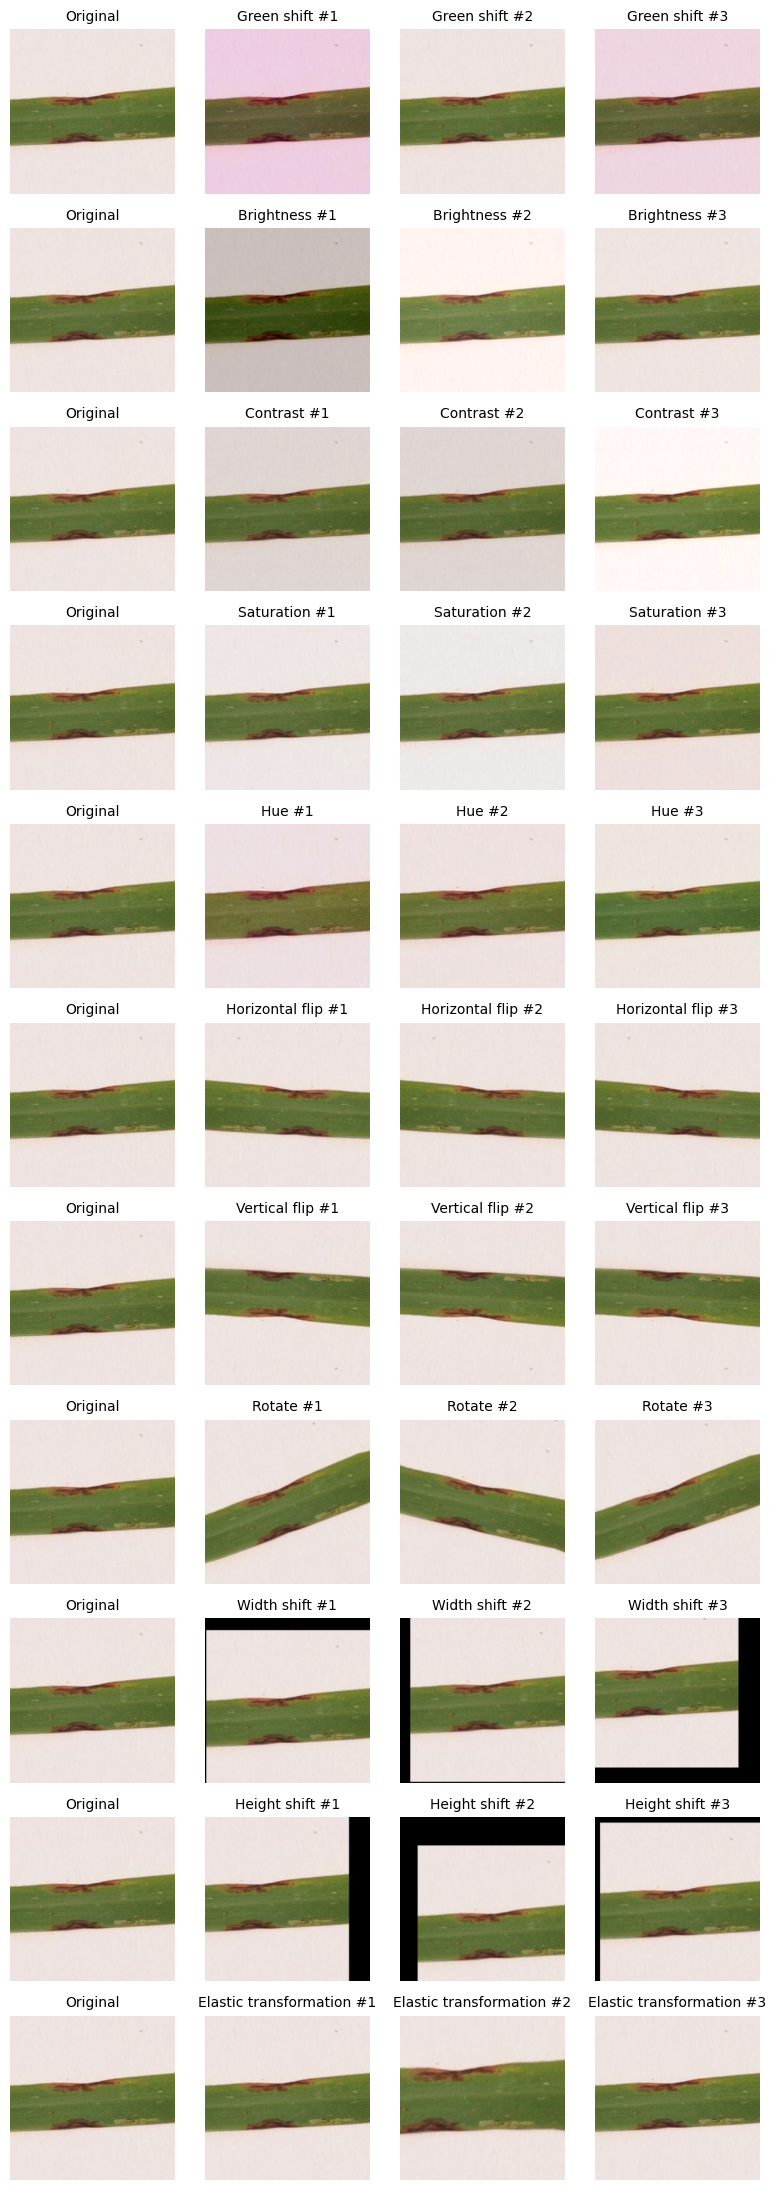

In [ ]:
# Apply augmentations and plot
fig, axs = plt.subplots(len(augmentations), 4, figsize=(8, 2 * len(augmentations)))

for i, (aug_name, aug) in enumerate(augmentations):
    axs[i, 0].imshow(image)
    axs[i, 0].set_title("Original", fontsize= 10)
    axs[i, 0].axis('off')

    for j in range(1, 4):
        augmented_image = aug(image=image)['image']
        axs[i, j].imshow(augmented_image)
        axs[i, j].set_title(f"{aug_name} #{j}", fontsize= 10)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()